In [1]:
library(edgeR)
library(ggplot2)
library(glue)

Loading required package: limma

Warning message:
“package ‘ggplot2’ was built under R version 4.0.0”


## 1. load in data

In [2]:
raw_filename            = '../data/16p12_lcl_gene_reads_underscores.gct'
pheno_filename          = '../data/pheno_final.tsv'
mapping_filename        = '../data/gene_names_mapping_simple.tsv'

In [3]:
mapping             = read.table(mapping_filename, sep='\t', header=TRUE, stringsAsFactors = F)
rownames(mapping)   = mapping$Name

In [4]:
pheno                   = read.table(pheno_filename, sep='\t', header=TRUE)
rownames(pheno)         = pheno$sample

In [5]:
rawdf               = read.table(raw_filename, sep='\t', header=TRUE)
rownames(rawdf)     = rawdf$Name
rawdf$Name          = NULL

In [6]:
gencode2ensembl = function(s) {
    return(strsplit(s, '.', fixed=T)[[1]][1])
}

rownames(rawdf) = unlist(lapply(rownames(rawdf), gencode2ensembl))
rawmat          = as.matrix(rawdf)

pheno = pheno[colnames(rawmat),]

In [7]:
contrast_map = function(design, group) {
    group = paste0('group', group)
    pos = (1:length(colnames(design)))[colnames(design) == group]
    return(pos)
}

In [8]:
group         = pheno$status3
family        = pheno$family

In [9]:
y = DGEList(counts=rawmat, group=group)
keep = filterByExpr(y)
y = y[keep,,keep.lib.sizes=FALSE]
y = calcNormFactors(y)

In [10]:
write.table(names(keep[keep]), 'output/edgr_final/keep_carrier_non_carrier.txt', 
            row.names = F, col.names = F, quote = F)


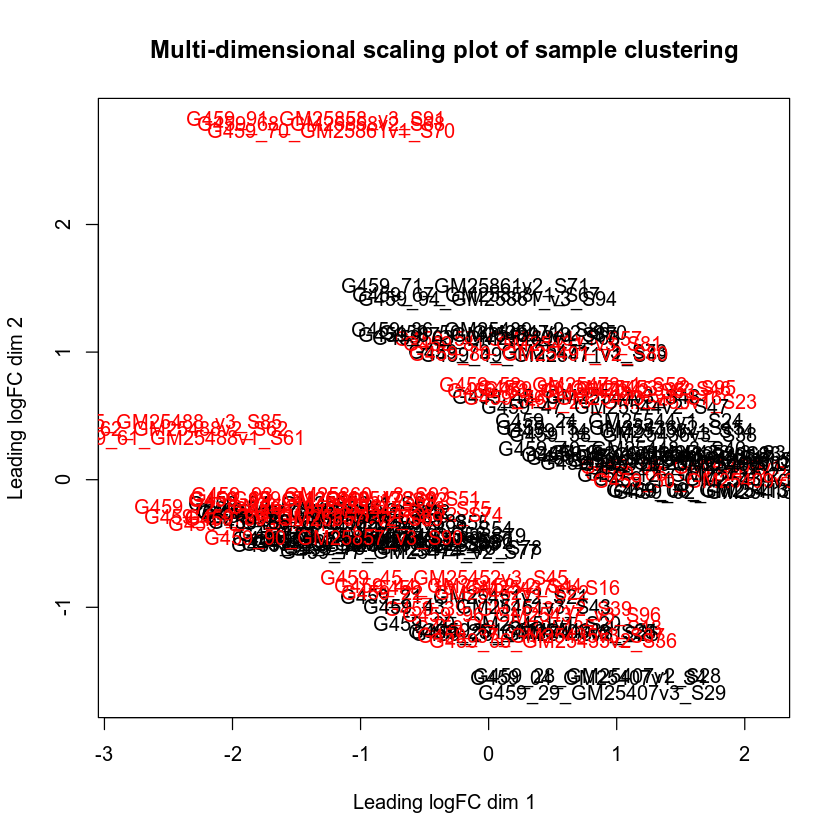

In [11]:
plotMDS(y, col=as.numeric(y$samples$group))
title(main="Multi-dimensional scaling plot of sample clustering")

In [12]:
#Create the design matrix for all samples
design        = model.matrix(~0+group+family)
rownames(design) = colnames(y)
#Estimate dispersion of variances along model
y = estimateDisp(y, design, robust=TRUE)
#Model the quasi-lielihood dispersions of variation within model
fit = glmQLFit(y, design, robust=TRUE)

In [13]:
contrast_map = function(design, group) {
    group = paste0('group', group)
    pos = (1:length(colnames(design)))[colnames(design) == group]
    return(pos)
}

In [14]:
contrast = numeric(length(colnames(design)))
contrast[contrast_map(design, 'non_carrier')] = -1
contrast[contrast_map(design, 'carrier')] = 1

In [15]:
effectiveLibSize<-y$samples$lib.size*y$samples$norm.factors
normCounts<-log2(t(t(y$counts+0.5) / (effectiveLibSize+0.5)))

In [16]:
qlf = glmQLFTest(fit,contrast=contrast)

In [17]:
topdf = topTags(qlf, n=56202, p.value=0.05)$table

In [18]:
topdf['gene'] = mapping[rownames(topdf), 'Description']
topdf = topdf[c('gene', 'logFC', 'logCPM', 'F', 'PValue', 'FDR')]

In [19]:
diff_save = cbind(rownames(topdf), topdf)
colnames(diff_save)[1] = "ensembl"
write.table(diff_save, 'output/edgr_final/carrier_non_carrier_family_corrected.tsv', sep='\t', row.names=F, col.names=T)


